# Test of alignment scores and functions for the attention mechanism

How do the different scores differ? What are advantages, disadvantages?

A first test only.

In [3]:
# test alignment functions
import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def fscore(x, y, mthd='dot', w=np.ones((1,1))):
    '''compute alignment score for attention'''
    if mthd == 'dot':
        return x.dot(y.T)
    elif mthd == 'cos':
        return x.dot(y.T) / np.linalg.norm(x) / np.linalg.norm(y)
    elif mthd == 'wght': # with projections
        return x.dot(w.dot(y.T))
    elif mthd == 'tanh':
        return np.tanh(x.dot(w.dot(y.T)))
    elif mthd == 'euc':
        return 1 - np.linalg.norm(x-y)
    elif mthd == 'ent':
        return x.dot(np.log(1+y))
    else:
        return np.zeros_like(x)

if __name__ == "__main__":
    a0 = np.array([.1, .1, .5])
    a1 = np.array([.1, .5, .1])
    print('score dot: ', fscore(a0, a1, 'dot'))
    print('align dot: ', softmax(fscore(a0, a1, 'dot')))
    print('score cosine: ', fscore(a0, a1, 'cos'))
    print('align cosine: ', softmax(fscore(a0, a1, 'cos')))
    #w0 = np.random.random((3,3))
    w0 = np.array([[1, 1, -1], [1, -1, 1], [-1, 1, 1]])
    print('score weighted: ', fscore(a0, a1,'wght', w0))
    print('align weighted: ', softmax(fscore(a0, a1,'wght', w0)))
    print('score tanh: ', fscore(a0, a1,'tanh', w0))
    print('align tanh: ', softmax(fscore(a0, a1,'tanh', w0)))
    print('score euclidean: ', fscore(a0, a1, 'euc'))
    print('align euclidean: ', softmax(fscore(a0, a1, 'euc')))
    print('score entr: ', fscore(a0, a1, 'ent'))
    print('align entr: ', softmax(fscore(a0, a1, 'ent')))

score dot:  0.11000000000000001
align dot:  1.0
score cosine:  0.4074074074074074
align cosine:  1.0
score weighted:  0.27
align weighted:  1.0
score tanh:  0.26362483547220333
align tanh:  1.0
score euclidean:  0.4343145750507619
align euclidean:  1.0
score entr:  0.0977326186934114
align entr:  1.0


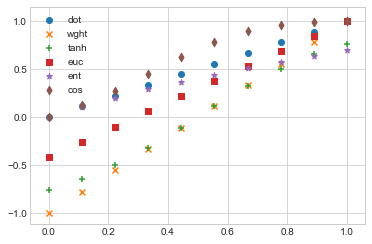

In [5]:
# test alignment functions
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def fscore(x, y, mthd='dot', w=np.ones((1,1))):
    '''compute alignment score for attention'''
    if mthd == 'dot':
        return x.dot(y.T)
    elif mthd == 'cos':
        return x.dot(y.T) / np.linalg.norm(x) / np.linalg.norm(y)
    elif mthd == 'wght': # with projections
        return x.dot(w.dot(y.T))
    elif mthd == 'tanh':
        return np.tanh(x.dot(w.dot(y.T)))
    elif mthd == 'euc':
        return 1 - np.linalg.norm(x-y)
    elif mthd == 'ent':
        return x.dot(np.log(1+y))
    else:
        return np.zeros_like(x)

if __name__ == "__main__":
    plt.style.use('seaborn-whitegrid')
    a0 = np.array([1, 0])
    x = np.linspace(0, 1, 10)
    y0 = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    #w0 = np.random.random((2,2))
    w0 = np.array([[1, -1], [-1, 1]])
    for xv in x:
        a1 = np.array([xv, 1. - xv])
        y0.append(fscore(a0, a1, 'dot'))
        y1.append(fscore(a0, a1, 'wght', w0))
        y2.append(fscore(a0, a1, 'tanh', w0))
        y3.append(fscore(a0, a1, 'euc', w0))
        y4.append(fscore(a0, a1, 'ent', w0))
        y5.append(fscore(a0, a1, 'cos', w0))
    plt.scatter(x, y0, marker='o', label='dot')
    plt.scatter(x, y1, marker='x', label='wght')
    plt.scatter(x, y2, marker='+', label='tanh')
    plt.scatter(x, y3, marker='s', label='euc')
    plt.scatter(x, y4, marker='*', label='ent')
    plt.scatter(x, y5, marker='d', label='cos')
    plt.legend()
    plt.show()
    #print(y0)

## Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We compute the attention function on a set of queries simultaneously, packed together into a matrix . The keys and values are also packed together into matrices.

Multihead: Attention(Q,K,V) = softmax(Q * K.T / sqrt(dk)) * V
This makes sense: How similar are the queries Q to the keys K (=Q * K.T)? If queries and keys are similar, more attention is given to the respective section (weighted by values V).

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions: MultiHead(Q, K, V) = Concat(head1 , . . . , headh)WO, headi = Attention(Q*WiQ, K*WiK, V*WiV) with projection matrices WiQ, WiK, WiV = parameters (i.e. the weight matrices from the linear model).

torch.nn.Linear: Applies a linear transformation to the incoming data: y = xA^T + by

In [1]:
import torch
import torch.nn.functional as F
import math

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) # a.size(-1) refers to the last dimension
    print('d_k: ', d_k)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # transpose(dim0, dim1) = second-last and last
    print('query: ', query, ' key: ', key, ' key.T: ', key.transpose(-2, -1))
    print('scores: ', scores)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    print('p_attn: ', p_attn)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

if __name__=='__main__':
    #q = torch.rand(2,2)
    #k = torch.rand(2,2)
    #v = torch.rand(2,2)
    q = torch.tensor([[1., 0.], [0., 1.]])
    k = torch.tensor([[0.1, 1.1], [1.2, 0.2]])
    v = torch.tensor([[0., 0.], [1., 1.]])
    print(attention(q, k, v))

d_k:  2
query:  tensor([[1., 0.],
        [0., 1.]])  key:  tensor([[0.1000, 1.1000],
        [1.2000, 0.2000]])  key.T:  tensor([[0.1000, 1.2000],
        [1.1000, 0.2000]])
scores:  tensor([[0.0707, 0.8485],
        [0.7778, 0.1414]])
p_attn:  tensor([[0.3148, 0.6852],
        [0.6539, 0.3461]])
(tensor([[0.6852, 0.6852],
        [0.3461, 0.3461]]), tensor([[0.3148, 0.6852],
        [0.6539, 0.3461]]))


In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)